In [ ]:
# Importa modulos en Google Colab. OJO: Ejecutar dos veces.

import os # Configura GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Reemplaza por "" para usar CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Importar Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Instala Sionna en Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configura el notebook para usar un solo GPU y no reservar toda la memoria
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Evita log de errores de TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np
import pandas as pd

# Ploteo
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
# Importa modulos en entorno local. OJO: No ejecutar en Google Colab.

import sionna

# Configura el notebook para usar un solo GPU y no reservar toda la memoria
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # 0=INFO,1=WARNING,2=ERROR,3=FATAL


import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Evita log de errores de TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np
import pandas as pd

# Ploteo
%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
# Parametros generales

sionna.phy.config.seed = 0 # semilla para reproducibilidad
N = 128 # longitud del código
K = 64 # número de bits de información (antes de CRC)
bitsxsimb = 1 # bits por símbolo (BPSK)
list_scl = 8 # tamaño de lista para SCL

# Parametros de ploteo
EBNO_DB_MIN = 0 # Eb/N0 mínimo en dB para ploteo
EBNO_DB_MAX = 25 # Eb/N0 máximo en dB para ploteo
LOTE = 500 # tamaño de lote para ploteo

In [16]:
# Canal AWGN
def canalAWGN(ebno_db, bitsxsimb, coderate, x):
    no = sionna.phy.utils.ebnodb2no(ebno_db, bitsxsimb, coderate=coderate) # sin codigo de canal
    awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
    awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
    awgn = tf.complex(awgn_real, awgn_imag)
    y = x + awgn
    return no, y

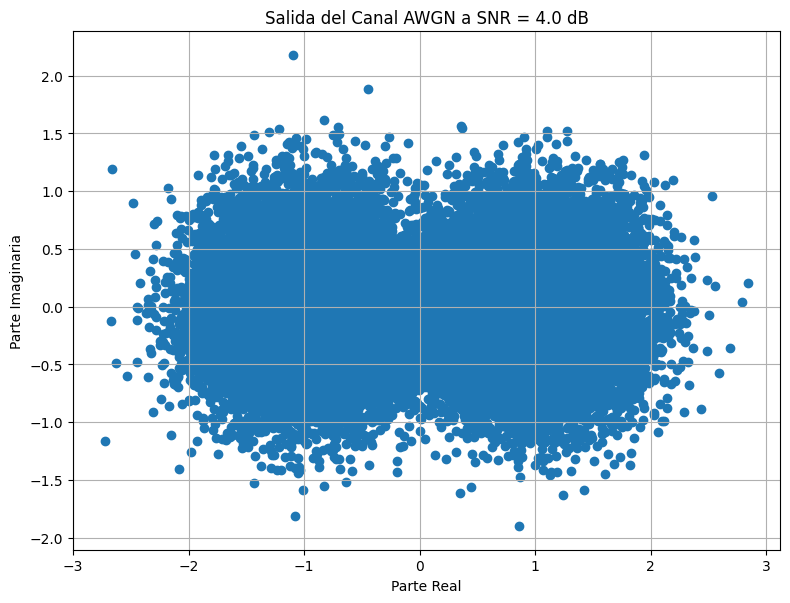

In [17]:
# Prueba el correcto funcionamiento del sistema con canal AWGN

snr_prueba = 4.0 # SNR de prueba en dB
datos = sionna.phy.mapping.BinarySource()
constelacion = sionna.phy.mapping.Constellation("pam", bitsxsimb) # para mas bitsxsimb usar "qam"
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion)
demapeador_llr = sionna.phy.mapping.Demapper("app", constellation=constelacion)
demapeador_hard = sionna.phy.mapping.Demapper("app", constellation=constelacion, hard_out=True)
b = datos([LOTE, K])
x = mapeador(b)

# Canal AWGN
no, y = canalAWGN(snr_prueba, bitsxsimb, coderate=1.0, x=x)

# Demapeo LLR
llr = demapeador_llr(y, no)
b_hat = demapeador_hard(y, no)

# Grafico de constelacion
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Salida del Canal AWGN a SNR = {} dB'.format(snr_prueba))
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

# Verificar dimensiones y valores de las variables luego de la ejecucion

In [18]:
# Prueba de variables

print("x:", x[0, :3])
print("y:", y[0, :3])
print("llr:", llr[0, :3])
err = tf.math.count_nonzero(tf.not_equal(b, b_hat), dtype=tf.int32)
print("err:", int(err.numpy()))

x: tf.Tensor([-1.+0.j -1.+0.j  1.+0.j], shape=(3,), dtype=complex64)
y: tf.Tensor([-1.0459139 -0.08858193j -0.06913936+0.5696364j   1.1388382 +0.3854556j ], shape=(3,), dtype=complex64)
llr: tf.Tensor([ 10.508868    0.6946802 -11.442531 ], shape=(3,), dtype=float32)
err: 389


In [19]:
# Define la clase del sistema sin código de canal

class SinCodigAWGN(sionna.phy.Block):
    def __init__(self, N, bitsxsimb):
        super().__init__()
        self.N = N
        self.bitsxsimb = bitsxsimb
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.constelacion = sionna.phy.mapping.Constellation("pam", self.bitsxsimb) # para mas bitsxsimb usar "qam"
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = self.datos([batch_size, self.N])
        x = self.mapeador(b)
        
        # Canal AWGN
        no, y = canalAWGN(ebno_db, self.bitsxsimb, coderate=1.0, x=x)

        # Demapeo LLR
        llr = self.demapeador(y, no)

        return b, llr

In [20]:
# Se inicializa la clase con parametros generales

sin_codigo_awgn = SinCodigAWGN(K, bitsxsimb) # K, porque N es valor con codigo de canal

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 8.1812e-02 | 9.9600e-01 |        2618 |       32000 |          498 |         500 |         0.0 |reached target block errors
      1.0 | 5.7469e-02 | 9.7000e-01 |        1839 |       32000 |          485 |         500 |         0.0 |reached target block errors
      2.0 | 3.5406e-02 | 9.0200e-01 |        1133 |       32000 |          451 |         500 |         0.0 |reached target block errors
      3.0 | 2.2969e-02 | 7.6400e-01 |         735 |       32000 |          382 |         500 |         0.0 |reached target block errors
      4.0 | 1.2313e-02 | 5.4400e-01 |         394 |       32000 |          272 |         500 |         0.0 |reached target block errors
      5.0 | 5.3750e-03 | 2.8600e-01 |         172 |       32000 |

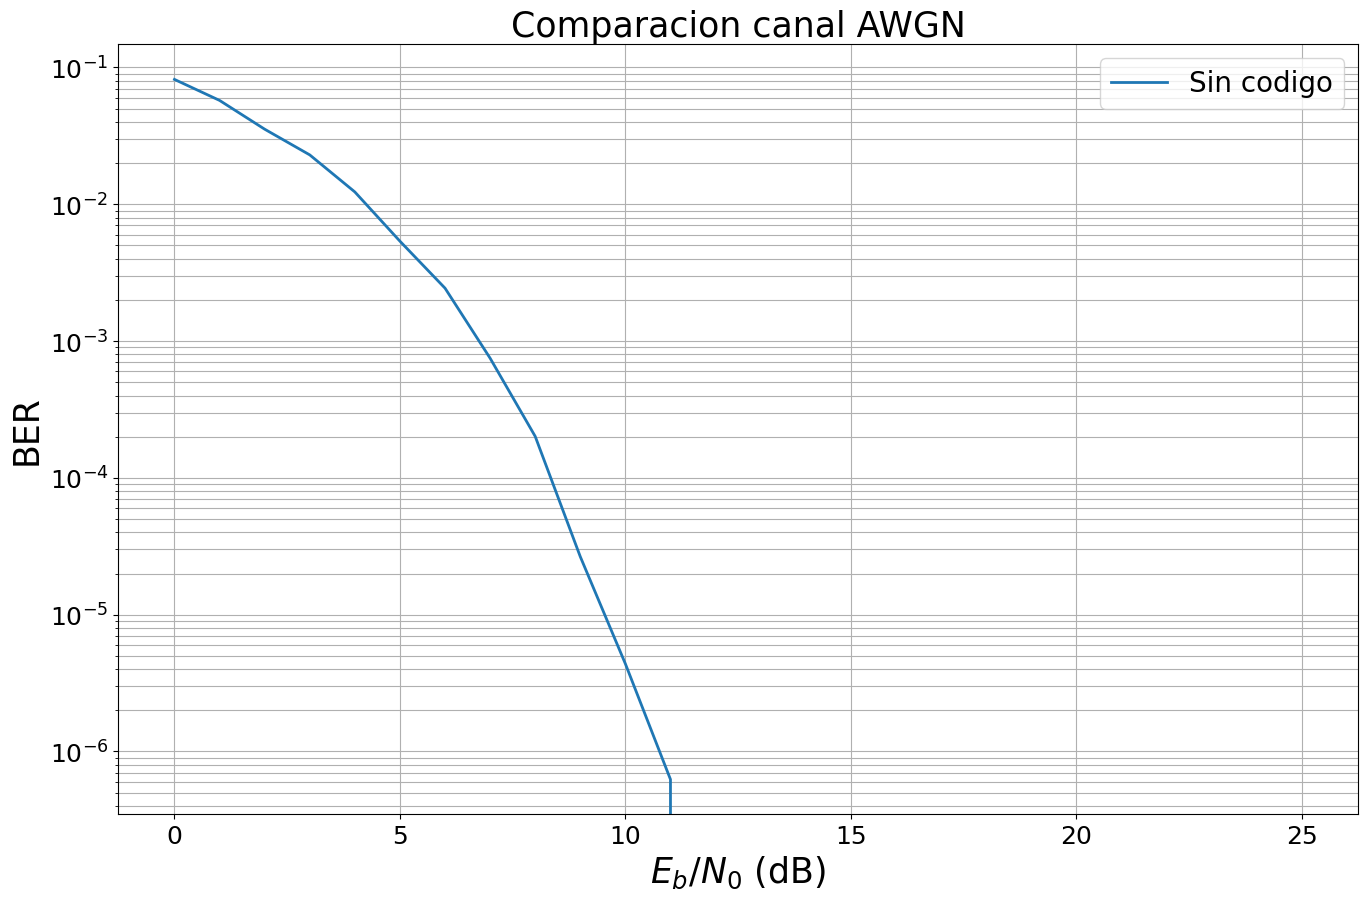

In [21]:
# Simulación y ploteo de BER

ber_plots = sionna.phy.utils.PlotBER("Comparacion canal AWGN")
ber_plots.simulate(sin_codigo_awgn,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_DB_MAX - EBNO_DB_MIN + 1),
                   batch_size=LOTE,
                   num_target_block_errors=100,
                   legend="Sin codigo",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True);

In [22]:
# Generador Monte Carlo de bits congelados con XLA acceleration

# Función compilada XLA para simulacion de batch_size
@tf.function(jit_compile=True)
def simulacion_batch_size(snr_prueba, bitsxsimb, batch_size, no, datos, codificador, mapeador, demapeador, decodificador):
    # Bloques de transmision
    bits = datos([batch_size, 1]) # solo 1 bit de datos por bit-canal
    bits_codif = codificador(bits) # codifica a N bits
    x = mapeador(bits_codif)

    # Canal AWGN complejo
    no, y = canalAWGN(snr_prueba, bitsxsimb, coderate=1.0/N, x=x)

    # Demapeo LLR
    llr = demapeador(y, no)
    bits_decodif = decodificador(llr)

    # Cálculo de errores y borrado de variables intermedias
    err = tf.math.count_nonzero(tf.not_equal(bits, bits_decodif), dtype=tf.int32)
    del bits, bits_codif, x, y, llr, bits_decodif
    
    return tf.cast(err, tf.int64), tf.constant(batch_size, dtype=tf.int64)

# Parámetros de la simulacion
batch_size = 2000 # Emplea la VRAM de la GPU
num_iter = 2000 # Itera para incrementar simulaciones por bit-canal
# Info: Cada bit-canal se simula batch_size * num_iter veces
snr_prueba = 4.0 # Recomendacion de paper de Sun y Zhang

# Inicializa los bloques necesarios
BER_bits = np.zeros(N)
datos = sionna.phy.mapping.BinarySource()
constelacion = sionna.phy.mapping.Constellation("pam", bitsxsimb)
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion)
demapeador = sionna.phy.mapping.Demapper("app", constellation=constelacion)

for i in range(N):
    print(f"Procesando bit-canal {i+1}/{N}", end="", flush=True)

    # Se setean los bits congelados y reinicia conteo errores
    bits_congelados = np.array([j for j in range(N) if j != i]) # se analiza cada bit-canal
    codificador = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
    decodificador = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=list_scl)
    errores_totales = 0
    bits_totales = 0

    # Se itera varias veces para acumular errores
    for b in range(num_iter):
        # Ejecuta iteración compilada con XLA
        err, total = simulacion_batch_size(snr_prueba, bitsxsimb, batch_size, no, datos, codificador, mapeador, demapeador, decodificador)
        errores_totales += int(err.numpy())
        bits_totales += int(total.numpy())

    print()
    BER_bits[i] = errores_totales / bits_totales

# Resultados Monte Carlo
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]

Procesando bit-canal 1/128

I0000 00:00:1768497281.294928   51456 service.cc:152] XLA service 0x4a61bb50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768497281.294968   51456 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 3500 Ada Generation Laptop GPU, Compute Capability 8.9
I0000 00:00:1768497281.468400   51456 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1768497287.036951   51456 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Procesando bit-canal 2/128
Procesando bit-canal 3/128
Procesando bit-canal 4/128
Procesando bit-canal 5/128
Procesando bit-canal 6/128
Procesando bit-canal 7/128
Procesando bit-canal 8/128
Procesando bit-canal 9/128

2026-01-15 12:16:03.664222: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %gather.40 = f32[116,1,2000,16]{3,2,1,0} gather(f32[128,2000,16]{2,1,0} %broadcast.725, s64[116,1]{1,0} %constant.840), offset_dims={1,2,3}, collapsed_slice_dims={}, start_index_map={0}, index_vector_dim=1, slice_sizes={1,2000,16}, metadata={op_type="GatherV2" op_name="GatherV2_46" source_file="/home/sergio/miniconda3/envs/tf/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2026-01-15 12:16:03.805580: E external/local_xla


Procesando bit-canal 10/128
Procesando bit-canal 11/128
Procesando bit-canal 12/128
Procesando bit-canal 13/128
Procesando bit-canal 14/128
Procesando bit-canal 15/128
Procesando bit-canal 16/128
Procesando bit-canal 17/128
Procesando bit-canal 18/128
Procesando bit-canal 19/128
Procesando bit-canal 20/128
Procesando bit-canal 21/128
Procesando bit-canal 22/128
Procesando bit-canal 23/128
Procesando bit-canal 24/128
Procesando bit-canal 25/128
Procesando bit-canal 26/128
Procesando bit-canal 27/128
Procesando bit-canal 28/128
Procesando bit-canal 29/128
Procesando bit-canal 30/128
Procesando bit-canal 31/128
Procesando bit-canal 32/128
Procesando bit-canal 33/128
Procesando bit-canal 34/128
Procesando bit-canal 35/128
Procesando bit-canal 36/128
Procesando bit-canal 37/128
Procesando bit-canal 38/128
Procesando bit-canal 39/128
Procesando bit-canal 40/128
Procesando bit-canal 41/128
Procesando bit-canal 42/128
Procesando bit-canal 43/128
Procesando bit-canal 44/128
Procesando bit-cana

In [23]:
# Bloque de guardado de variables de simulacion Monte Carlo
# Asume batch_size siempre es 2000 (por uso de la VRAM)

output_dir = "resultados"
os.makedirs(output_dir, exist_ok=True)
df = pd.DataFrame({"BER bits": BER_bits})
filename = os.path.join(output_dir,f"AWGN_BER_bits_{N}_{K}_{num_iter}.csv")
df.to_csv(filename, index=True)

In [ ]:
# Bloque de recupero de variables de simulacion Monte Carlo
# Asume batch_size siempre es 2000 (por uso de la VRAM)

output_dir = "resultados"
num_iter = 1000 # OJO: debe coincidir con el usado en la simulacion
filename = os.path.join(output_dir,f"AWGN_BER_bits_{N}_{K}_{num_iter}.csv")
df = pd.read_csv(filename)
BER_bits = df["BER bits"].to_numpy()
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]

In [27]:
# Define la clase del sistema con código polar

class CodPolarAWGN(sionna.phy.Block):
    def __init__(self, N, K, bits_congelados, lista_SCL, bitsxsimb):
        super().__init__()
        self.N = N
        self.K = K
        self.bits_congelados = bits_congelados
        self.lista_SCL = lista_SCL
        self.bitsxsimb = bitsxsimb
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.polar_codif = sionna.phy.fec.polar.encoding.PolarEncoder(self.bits_congelados, self.N)
        self.constelacion = sionna.phy.mapping.Constellation("pam", self.bitsxsimb)
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        self.polar_decodif = sionna.phy.fec.polar.decoding.PolarSCLDecoder(self.bits_congelados, self.N, list_size=self.lista_SCL)
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = self.datos([batch_size, self.K])
        bits_codif = self.polar_codif(b)
        x = self.mapeador(bits_codif)

        # Canal AWGN
        no, y = canalAWGN(ebno_db, self.bitsxsimb, coderate=self.K/self.N, x=x)

        # Demapeo LLR
        llr = self.demapeador(y, no)
        b_hat = self.polar_decodif(llr)
        
        return b, b_hat

In [28]:
# Se inicializa la clase con los bits congelados obtenidos por Monte Carlo y parametros generales

cod_polar_awgn = CodPolarAWGN(N, K, bits_congelados, list_scl, bitsxsimb)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.7517e-01 | 6.7000e-01 |       17611 |       64000 |          670 |        1000 |         2.4 |reached target block errors
      1.0 | 1.1250e-01 | 2.9600e-01 |       14400 |      128000 |          592 |        2000 |         3.6 |reached target block errors
      2.0 | 2.2487e-02 | 5.9882e-02 |       12233 |      544000 |          509 |        8500 |        15.4 |reached target block errors
      3.0 | 1.2388e-03 | 3.3600e-03 |         991 |      800000 |           42 |       12500 |        23.6 |reached max iterations
      4.0 | 0.0000e+00 | 0.0000e+00 |           0 |      800000 |            0 |       12500 |        23.1 |reached max iterations

Simulation stopped as no error occurred @ EbNo = 4.0 dB.



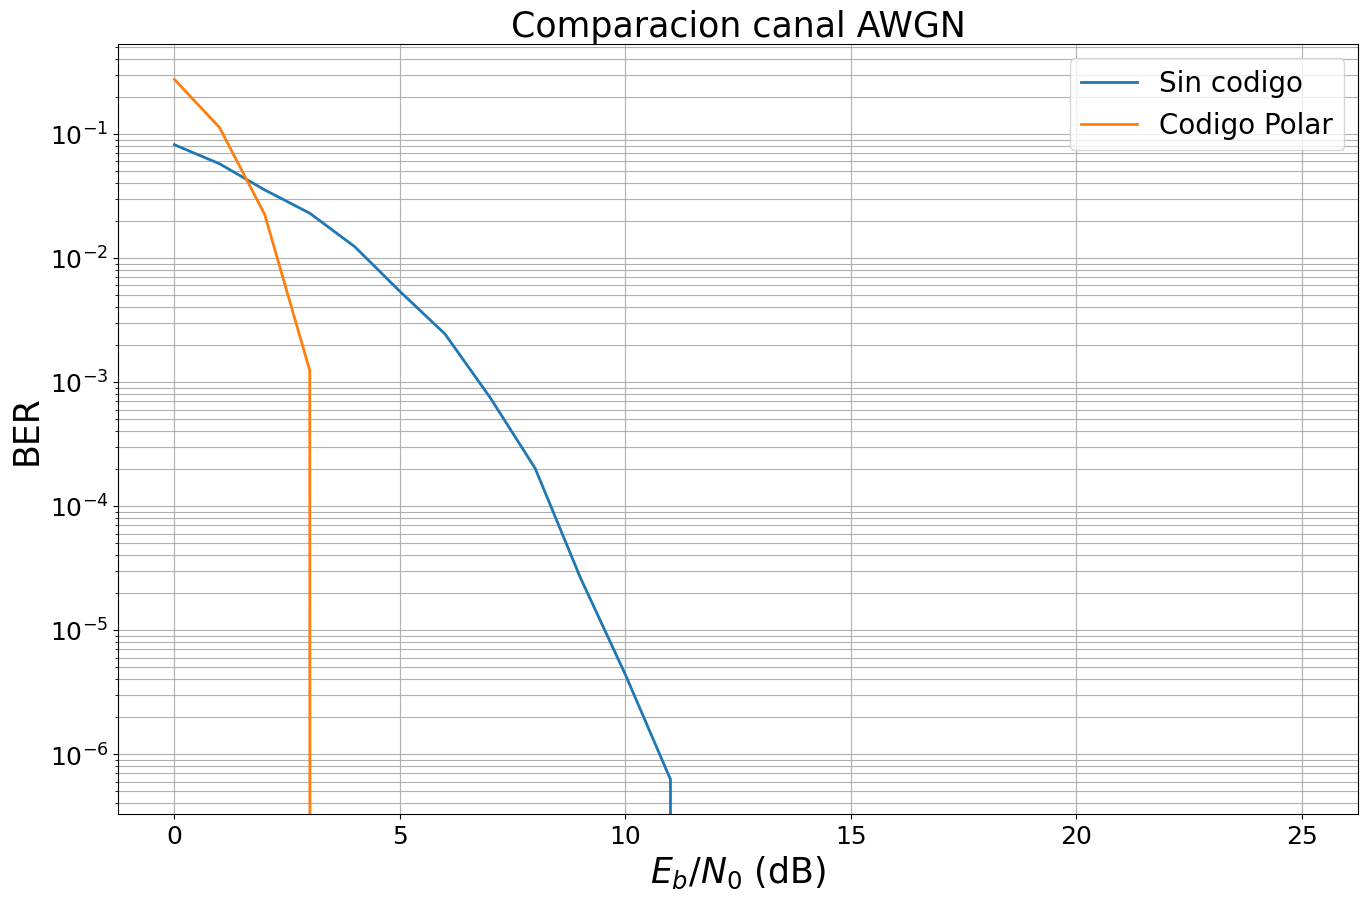

In [29]:
# Ploteo de la tasa de error para Codigo Polar

ber_plots.simulate(cod_polar_awgn,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, EBNO_DB_MAX - EBNO_DB_MIN + 1),
                   batch_size=LOTE,
                   num_target_block_errors=500,
                   legend="Codigo Polar",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);